In [1]:
import numpy as np

from matplotlib import cm

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

import math

In [23]:
def MakeDiscreteCells(l, w, maxEdgeLength=0.1):
    """
    l, w [float]: dimensions of 2D rectangular body
    
    maxEdgeLength [float]: max length of edge of any cell
    
    returns: array of tuples (2D points) and rectangular cells, indexed into points array.
    """
    assert(l>0)
    assert(w>0)
    
    points2d = []
    cells = []
    
    numRows = math.ceil(l / maxEdgeLength)
    numCols = math.ceil(w / maxEdgeLength)
    lDist = l / numRows
    wDist = w / numCols
    
    rowp2ds = [0]
    colp2ds = [0]
    n = 1
    k = 1
    
    for _ in range(numRows-1):
        rowp2ds.append(n*lDist)
        n += 1
    for _ in range(numCols-1):
        colp2ds.append(k*wDist)
        k += 1
    
    rowp2ds.append(l)
    colp2ds.append(w)
    
    # Generate 2D Points
    for rp in rowp2ds:
        for cp in colp2ds:
            points2d.append((cp, rp))
    
    # Generate Indexed Cells
    for i in range(len(points2d)-(len(colp2ds)+1)):
        if (i>0) and ((i+1)%len(colp2ds)==0):
            continue
    
        cell = [i, i+1, i+len(colp2ds)+1, i+len(colp2ds)]
        cells.append(cell)
    
    return points2d, cells

def VizMesh2D(points2d, cells, maxEdgeLength=0.1):
    """
    Given 2D Point and Quad/Rectangle cell information, visualizes the discretized 2D body.
    """
    xCoords, yCoords = zip(*points2d)
    
    # Dynamic aspect ratio
    maxW = max(xCoords) - min(xCoords)
    maxL = max(yCoords) - min(yCoords)
    aspectRatio = maxW / maxL
    base = 8
    width = base * aspectRatio if aspectRatio >= 1 else base
    length = base / aspectRatio if aspectRatio < 1 else base
    
    # Create the plot
    plt.figure(figsize=(width, length))
    plt.scatter(xCoords, yCoords, color='red', label='Mesh Points')  # Scatter plot of points
    
    # Draw the cells
    for cell in cells:
        # Get the corner points of the cell
        cellPoints = [points2d[cell[i]] for i in range(4)] + [points2d[cell[0]]]  # Close the rectangle
        cellX, cellY = zip(*cellPoints)
        plt.plot(cellX, cellY, color='blue')  # Plot cell edges
    
    # Draw the boundary of the rectangle
    rectX = [0, max(xCoords), max(xCoords), 0, 0]
    rectY = [0, 0, max(yCoords), max(yCoords), 0]
    plt.plot(rectX, rectY, color='black', linestyle='--', label='Rectangle Boundary')
    
    # Labels
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Discretized Mesh: ' + str(maxW) + " x " + str(maxL) + ", Max Edge Length = " + str(maxEdgeLength))
    plt.legend()
    plt.axis('equal')
    plt.show()


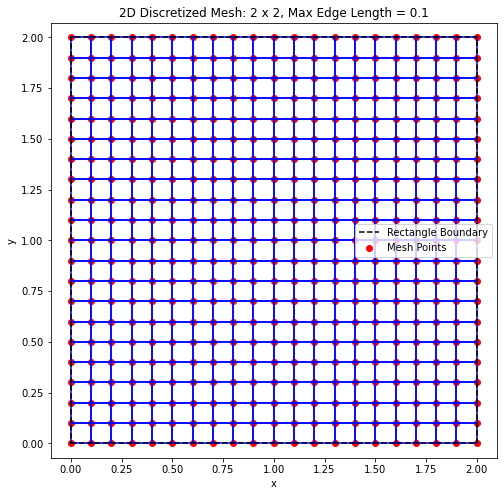

In [29]:
# Example 1
points, cells = MakeDiscreteCells(2, 2, 0.1)
VizMesh2D(points, cells)

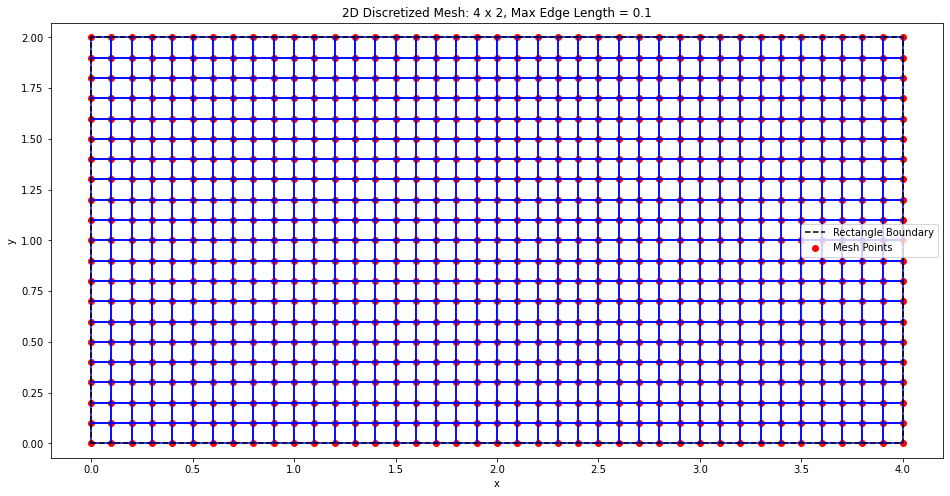

In [30]:
# Example 2
V, C = MakeDiscreteCells(2, 4, 0.1)
VizMesh2D(V, C)

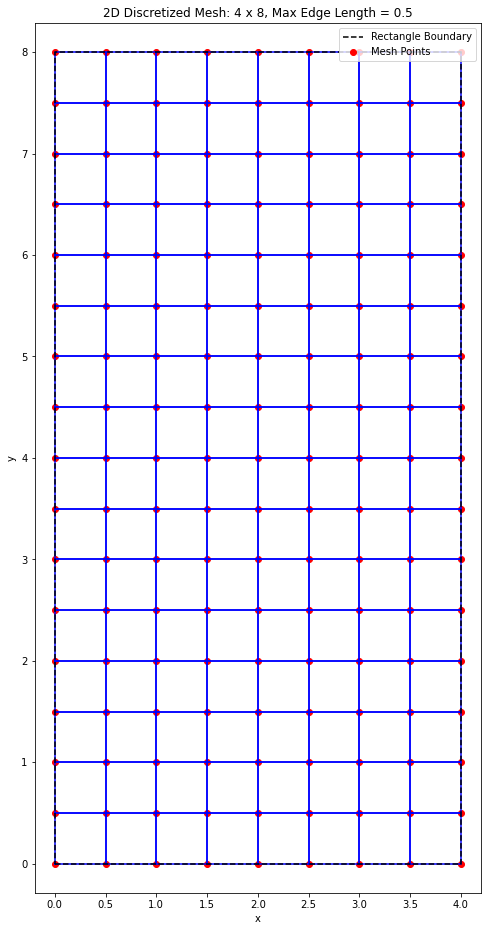

In [31]:
# Example 3
V, C = MakeDiscreteCells(8, 4, 0.5)
VizMesh2D(V, C, 0.5)

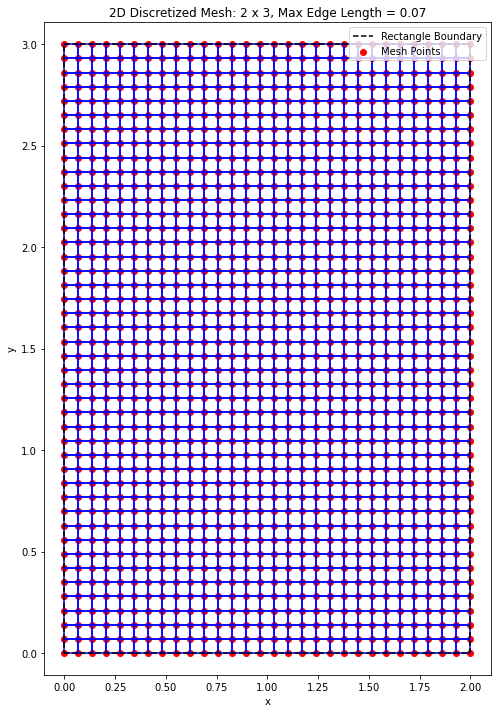

In [35]:
# Example 4
V, C = MakeDiscreteCells(3, 2, 0.07)
VizMesh2D(V, C, 0.07)

In [119]:
materials = {
    "aluminum": 0.025,
    "copper": 0.04,
    "steel": 0.005,
}

def SimulateHeatDiffusion2D(V, C, heatSourceIndex, temp, material, numSteps=100, snapshotTimes=[10, 50, 100], dt=0.1):
    """
    Simulates heat diffusion on a 2D rectangular mesh.
    
    V [List[Tuple[float, float]]]: List of 2D vertices (points)
    C [List[List[int, int, int, int]]]: List of rectangular cells (indices into V)
    heatSourceIndex [int]: Index of the cell where heat is applied
    temp [float]: Initial temperature of the heat source
    material [str]: String representing material type (maps to thermal diffusivity constant)
    numSteps [int]: Total simulation time steps
    snapshotTimes [List[int]]: List of time steps at which snapshots are taken
    dt [float]: Time step size
    
    Returns:
        snapshots [List[List[float]]]: List of temperature arrays for the specified snapshots
    """
    
    alpha = materials.get(material, 0.1)

    temperatures = np.zeros(len(V))  # initial temps
    snapshots = []

    # initial temperature at the heat source
    for vertex_idx in C[heatSourceIndex]:
        temperatures[vertex_idx] = temp

    # simulate heat transfer
    for step in range(1, numSteps + 1):
        new_temperatures = temperatures.copy()

        for cell in C:
            for vid in cell:
                # Identify neighbors of this vertex
                neighbors = [v for v in cell if v != vid]
                
                # Heat diffusion calculation (simplified version)
                new_temperatures[vid] += alpha * dt * sum(
                    temperatures[neighbor] - temperatures[vid] for neighbor in neighbors
                )
        
        temperatures = new_temperatures

        # Store snapshots at specified time steps
        if step in snapshotTimes:
            snapshots.append(temperatures.copy())

    return snapshots

def VizHeatSnapshots(V, C, snapshots, snapshotTimes, dt=0.1):
    fig, axes = plt.subplots(1, len(snapshots), figsize=(15, 5))

    for i, (temps, time) in enumerate(zip(snapshots, snapshotTimes)):
        ax = axes[i]
        for cell in C:
            
            # Temperature of the cell
            cellTemp = np.mean([temps[vid] for vid in cell])
            cellPoints = [V[vid] for vid in cell]
            
            # Plot cell w/ corresponding temp color
            polygon = plt.Polygon(cellPoints, closed=True, color=plt.cm.hot(cellTemp / max(temps)))
            ax.add_patch(polygon)

        ax.set_title(f'Time = {time * dt}')
        ax.set_xlim(0, max(v[0] for v in V))
        ax.set_ylim(0, max(v[1] for v in V))
        ax.set_aspect('equal')
    
    # Temperature color gradient
    plt.colorbar(plt.cm.ScalarMappable(cmap='hot'), ax=axes, orientation='horizontal', label='Scaled Temperature')
    plt.show()


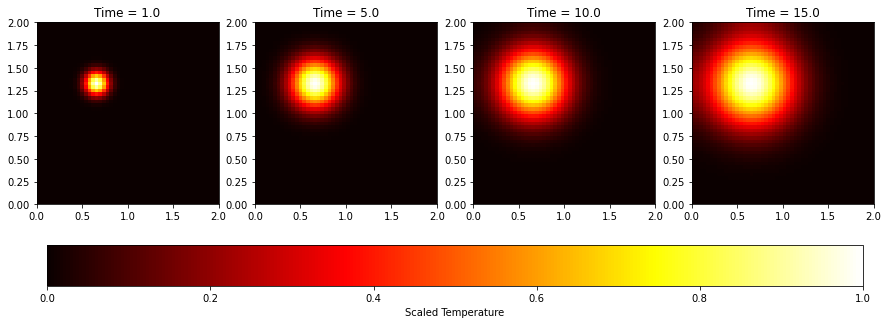

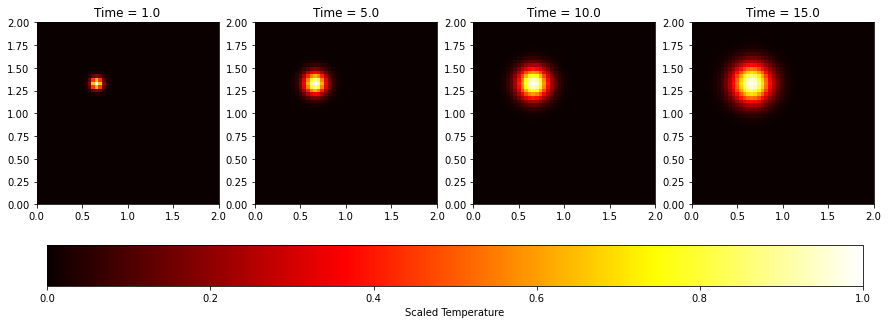

In [120]:
def SimulateHeatDiffusion2DWithDistances(V, C, heatSourceIndex, temp, material, numSteps=100, snapshotTimes=[10, 50, 100], dt=0.1):
    """
    Simulates heat diffusion on a 2D rectangular mesh, accounting for distances between vertices.
    
    Returns:
        snapshots [List[np.ndarray]]: List of temperature arrays for the specified snapshots
    """
    
    alpha = materials.get(material, 0.1)  # default to 0.1 if material is unknown

    temperatures = np.zeros(len(V))  # Initial temperature of each vertex
    snapshots = []

    # Set the initial temperature at the heat source
    for vertex_idx in C[heatSourceIndex]:
        temperatures[vertex_idx] = temp

    # Precompute pairwise distances for all vertices in each cell
    vertexDistances = {}
    for cell in C:
        for i in cell:
            for j in cell:
                if i != j:
                    vertexDistances[(i, j)] = np.linalg.norm(
                        np.array(V[i]) - np.array(V[j])
                    )

    # Time step loop
    for step in range(1, numSteps + 1):
        new_temperatures = temperatures.copy()

        for cell in C:
            for vid in cell:
                # Identify neighbors of this vertex within the same cell
                neighbors = [v for v in cell if v != vid]

                # Weighted heat diffusion based on distances
                for neighbor in neighbors:
                    distance = vertexDistances[(vid, neighbor)]
                    if distance > 0:
                        heatFlux = (temperatures[neighbor] - temperatures[vid]) / distance
                        new_temperatures[vid] += alpha * heatFlux * dt
        
        temperatures = new_temperatures

        if step in snapshotTimes:
            snapshots.append(temperatures.copy())

    return snapshots

V_, C_ = MakeDiscreteCells(2, 2, 0.04)
Vr, Cr = MakeDiscreteCells(2, 2, 0.04)

s_ = SimulateHeatDiffusion2DWithDistances(V_, C_, int(len(C_)/1.5), 270, "aluminum", 150, [10, 50, 100, 150])
sr = SimulateHeatDiffusion2DWithDistances(Vr, Cr, int(len(Cr)/1.5), 270, "steel", 150, [10, 50, 100, 150])

VizHeatSnapshots(V_, C_, s_, [10, 50, 100, 150])
VizHeatSnapshots(Vr, Cr, sr, [10, 50, 100, 150])

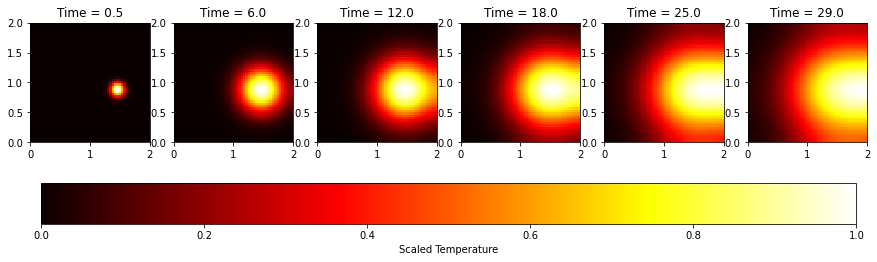

In [126]:
V, C = MakeDiscreteCells(2, 2, 0.04)
s1 = SimulateHeatDiffusion2DWithDistances(V, C, int(len(C)/2.2), 270, "copper", 300, [5, 60, 120, 180, 250, 290])
VizHeatSnapshots(V, C ,s1, [5, 60, 120, 180, 250, 290])

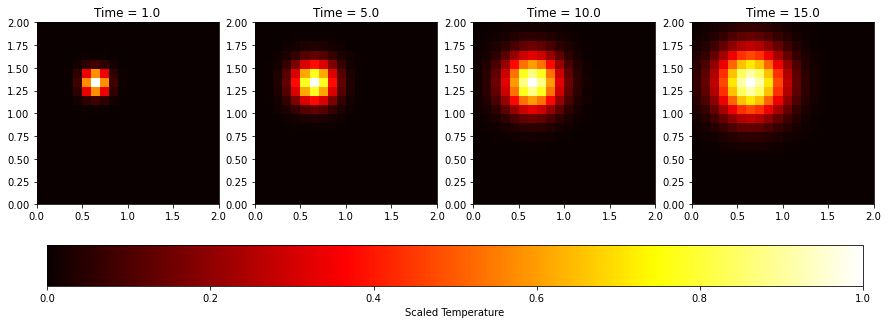

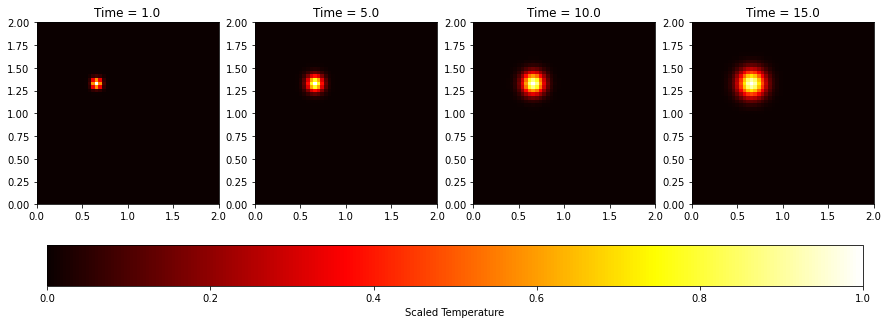

In [104]:
"""
Case: 2D, single point heat source. Comparing results with differing mesh refinements. No distance weighting.
"""

V1, C1 = MakeDiscreteCells(2, 2, 0.1)
V2, C2 = MakeDiscreteCells(2, 2, 0.04)

snapshots1 = SimulateHeatDiffusion2D(
    V1, C1, heatSourceIndex=(int(len(C1)/1.5)), temp=270, material="aluminum",
    numSteps=150, snapshotTimes=[10, 50, 100, 150]
)
snapshots2 = SimulateHeatDiffusion2D(
    V2, C2, heatSourceIndex=(int(len(C2)/1.5)), temp=270, material="aluminum",
    numSteps=150, snapshotTimes=[10, 50, 100, 150]
)

# Visualize snapshots
VizHeatSnapshots(V1, C1, snapshots1, snapshotTimes=[10, 50, 100, 150])
VizHeatSnapshots(V2, C2, snapshots2, snapshotTimes=[10, 50, 100, 150])

In [39]:
def MakeDiscreteCells3D(l, w, h, maxEdgeLength=0.1):
    """
    l, w, h [float]: Dimensions of the 3D rectangular body
    maxEdgeLength [float]: Maximum edge length of any 3D cuboid cell

    Returns:
    vertices: List of 3D vertices (x, y, z)
    cells: List of cuboid cells (indices into vertices)
    """

    numX = int(np.ceil(l / maxEdgeLength))
    numY = int(np.ceil(w / maxEdgeLength))
    numZ = int(np.ceil(h / maxEdgeLength))

    dx, dy, dz = l / numX, w / numY, h / numZ

    # Generate 3D points
    vertices = [(x * dx, y * dy, z * dz) for x in range(numX + 1)
                                         for y in range(numY + 1)
                                         for z in range(numZ + 1)]

    # Generate cells
    cells = []
    for x in range(numX):
        for y in range(numY):
            for z in range(numZ):
                idx = x * (numY + 1) * (numZ + 1) + y * (numZ + 1) + z
                cell = [
                    idx,
                    idx + 1,
                    idx + (numZ + 1),
                    idx + (numZ + 1) + 1,
                    idx + (numY + 1) * (numZ + 1),
                    idx + (numY + 1) * (numZ + 1) + 1,
                    idx + (numY + 1) * (numZ + 1) + (numZ + 1),
                    idx + (numY + 1) * (numZ + 1) + (numZ + 1) + 1,
                ]
                cells.append(cell)

    return vertices, cells

def viz3DMesh(vertices, cells, maxEdgeLength=0.1):
    """
    Visualize a 3D discretized body with its vertices and cells.
    
    Returns: None
    """
    
    x, y, z = zip(*vertices)

    # Create figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot vertices
    ax.scatter(x, y, z, color="red", label="Vertices", s=10)

    # Plot cuboid edges
    for cell in cells:
        # Get 8 vertices of the cuboid
        cellPoints = [vertices[idx] for idx in cell]

        # Edges of the cuboid
        edges = [
            [cellPoints[0], cellPoints[1], cellPoints[3], cellPoints[2]],  # Bottom face
            [cellPoints[4], cellPoints[5], cellPoints[7], cellPoints[6]],  # Top face
            [cellPoints[0], cellPoints[1], cellPoints[5], cellPoints[4]],  # Side face
            [cellPoints[2], cellPoints[3], cellPoints[7], cellPoints[6]],  # Side face
            [cellPoints[0], cellPoints[2], cellPoints[6], cellPoints[4]],  # Side face
            [cellPoints[1], cellPoints[3], cellPoints[7], cellPoints[5]],  # Side face
        ]

        # Add cuboid faces to the plot
        poly3d = [[list(point) for point in edge] for edge in edges]
        ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=0.1, edgecolors="blue", alpha=0.3))
    
    # Plot edges of the original bounding rectangular prism
    minX, maxX = min(x), max(x)
    minY, maxY = min(y), max(y)
    minZ, maxZ = min(z), max(z)

    # Define the 8 vertices of the bounding box
    boundingVertices = [
        (minX, minY, minZ), (maxX, minY, minZ), (maxX, maxY, minZ), (minX, maxY, minZ),  # Bottom
        (minX, minY, maxZ), (maxX, minY, maxZ), (maxX, maxY, maxZ), (minX, maxY, maxZ)   # Top
    ]

    # Define edges connecting the bounding vertices
    boundingEdges = [
        [boundingVertices[0], boundingVertices[1]], [boundingVertices[1], boundingVertices[2]], 
        [boundingVertices[2], boundingVertices[3]], [boundingVertices[3], boundingVertices[0]],  # Bottom face
        [boundingVertices[4], boundingVertices[5]], [boundingVertices[5], boundingVertices[6]], 
        [boundingVertices[6], boundingVertices[7]], [boundingVertices[7], boundingVertices[4]],  # Top face
        [boundingVertices[0], boundingVertices[4]], [boundingVertices[1], boundingVertices[5]], 
        [boundingVertices[2], boundingVertices[6]], [boundingVertices[3], boundingVertices[7]]   # Vertical edges
    ]

    # Add the edges to the plot
    for edge in boundingEdges:
        edgeX, edgeY, edgeZ = zip(*edge)
        ax.plot(edgeX, edgeY, edgeZ, color="black", label="Original Body" if "Original Body" not in ax.get_legend_handles_labels()[1] else None)

    # Set labels and legend
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Discretized Body: " + str(maxX) + " x " + str(maxY) + " x " + str(maxZ) + "; Max Edge Length = " + str(maxEdgeLength))
    ax.legend()

    # Equal aspect ratio for better visualization
    max_range = max(max(x) - min(x), max(y) - min(y), max(z) - min(z)) / 2.0
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()
    return


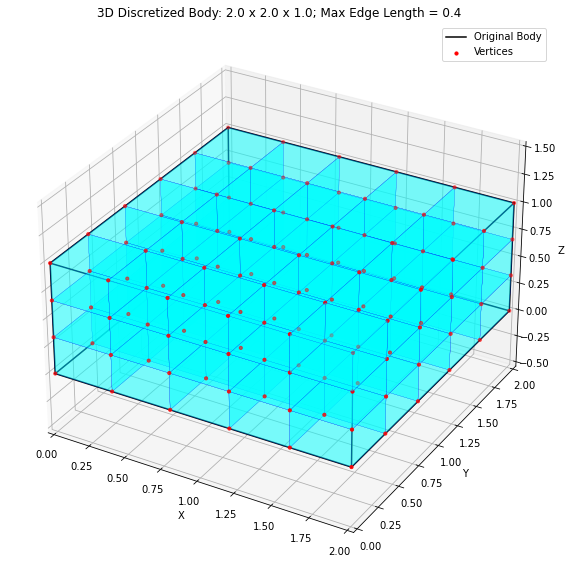

In [41]:
# Example 1
V, C = MakeDiscreteCells3D(2, 2, 1, 0.4)
viz3DMesh(V, C, 0.4)

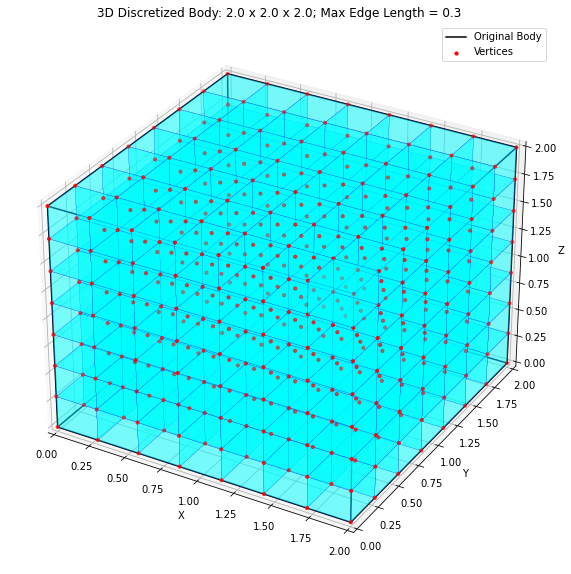

In [44]:
# Example 2
V, C = MakeDiscreteCells3D(2, 2, 2, 0.3)
viz3DMesh(V, C, 0.3)

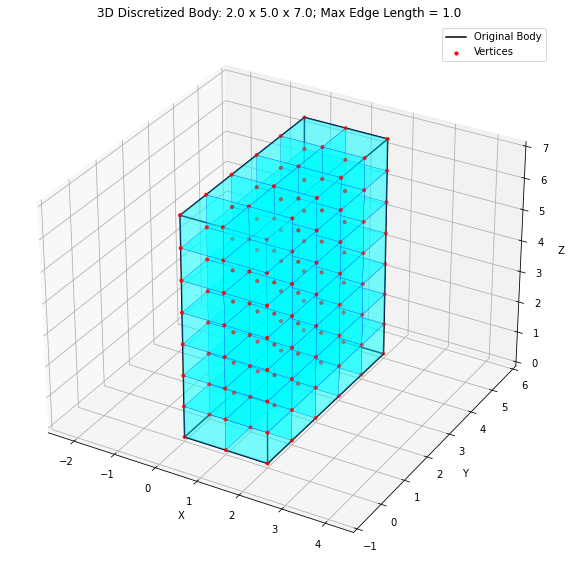

In [48]:
# Example 3
V, C = MakeDiscreteCells3D(2, 5, 7, 1)
viz3DMesh(V, C, 1.0)

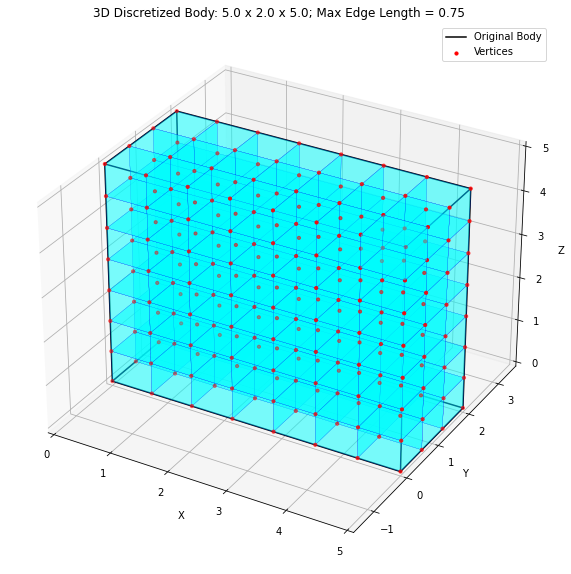

In [49]:
# Example 4
V, C = MakeDiscreteCells3D(5, 2, 5, 0.75)
viz3DMesh(V, C, 0.75)

In [130]:

materials = {
    "copper": 0.05,
    "aluminum": 0.02,
    "steel": 0.005
}

def SimulateHeatDiffusion3D(vertices, cells, heatSourceIdx, heatSourceTemp, material, 
                            numSteps=100, snapshotTimes=[10, 50, 100], dt=0.1):
    """
    Simulates heat diffusion on a 3D body.
        
    Returns:
    snapshots: List of temperature distributions at selected timesteps.
    """

    alpha = materials.get(material, 0.01)  # Default alpha
    temperatures = np.zeros(len(vertices))
    snapshots = []

    for vertexIdx in cells[heatSourceIdx]:
        temperatures[vertexIdx] = heatSourceTemp

    for step in range(1, numSteps + 1):
        newTemperatures = temperatures.copy()

        for cell in cells:
            for vertexIdx in cell:
                neighbors = [v for v in cell if v != vertexIdx]
                newTemperatures[vertexIdx] += alpha * dt * sum(
                    temperatures[n] - temperatures[vertexIdx] for n in neighbors
                )

        temperatures = newTemperatures

        if step in snapshotTimes:
            snapshots.append(temperatures.copy())
    
    return snapshots

def vizHeatDiffusion3D(vertices, snapshots, snapshotTimes, dt=0.1):
    """
    Visualize 3D heat diffusion snapshots over time.
    """
    numSnapshots = len(snapshots)
    
    fig = plt.figure(figsize=(15, 5))
    
    for i, (temp, time) in enumerate(zip(snapshots, snapshotTimes)):
        
        ax = fig.add_subplot(1, numSnapshots, i + 1, projection="3d")
        ax.set_title(f"Time: {time * dt}")
        
        x, y, z = zip(*vertices)
        
        # Scatter plot for temperature values
        scatter = ax.scatter(x, y, z, c=temp, cmap="hot", s=50, alpha=0.8)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        #ax.set_zlabel("Z")
        
        # Add color bar
        cbar = fig.colorbar(scatter, ax=ax, orientation="vertical", shrink=0.5)
        cbar.set_label("Temperature")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

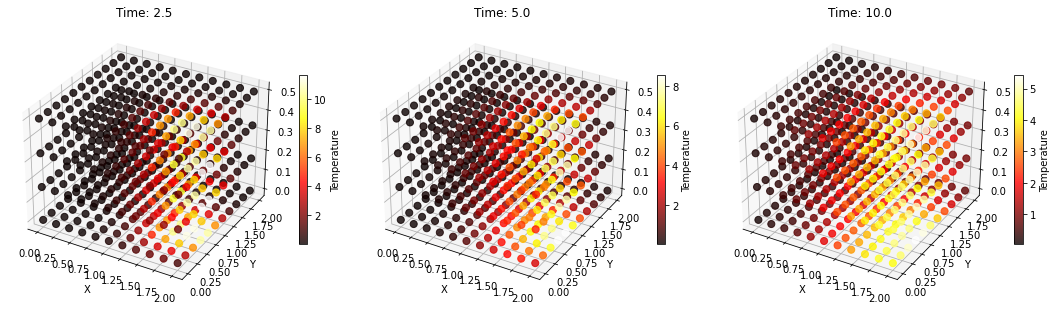

In [131]:
# Example 1
V, C = MakeDiscreteCells3D(2, 2, 0.5, 0.2)
snapshots = SimulateHeatDiffusion3D(V, C, int(len(C)-50), 100, "copper", 100, [25, 50, 100], 0.1)
vizHeatDiffusion3D(V, snapshots, [25, 50, 100])

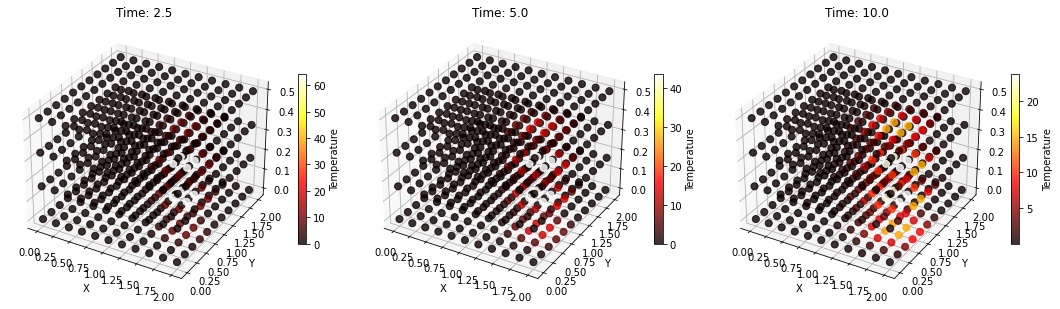

In [132]:
# Example 2
V, C = MakeDiscreteCells3D(2, 2, 0.5, 0.2)
snapshots = SimulateHeatDiffusion3D(V, C, int(len(C)-50), 100, "steel", 100, [25, 50, 100], 0.1)
vizHeatDiffusion3D(V, snapshots, [25, 50, 100])

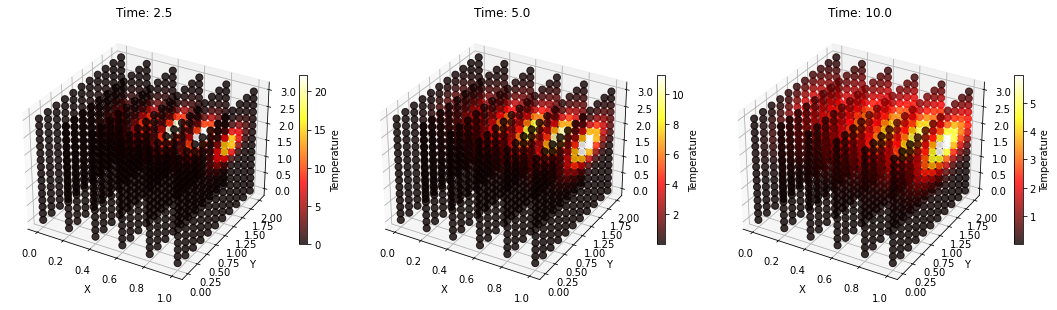

In [134]:
# Example 3
V, C = MakeDiscreteCells3D(1, 2, 3, 0.2)
snapshots = SimulateHeatDiffusion3D(V, C, int(len(C) - 200), 100, "aluminum", 100, [25, 50, 100], 0.1)
vizHeatDiffusion3D(V, snapshots, [25, 50, 100])